In [1]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
# starfile_path = "output.star"
starfile_path = None

# GeoLlama Report

In [3]:
import starfile

In [33]:
from datetime import datetime, timedelta
import re
from pathlib import Path

from IPython.display import Markdown, display

import numpy as np
import pandas as pd
from umap import UMAP

from scipy.spatial import Voronoi, voronoi_plot_2d

import matplotlib.pyplot as plt
import cv2
from matplotlib import cm
import seaborn as sns

from sklearn.cluster import DBSCAN

import mrcfile


In [5]:
from scipy.spatial import ConvexHull

def calc_voronoi_centroids(Vor_obj, label, latent_ensemble, debug=False):
    ptp_bound = np.ptp(latent_ensemble, axis=0)
    points_tr = latent_ensemble.T
    
    bounding_box = np.array([
        [points_tr[0].min() - ptp_bound[0]*0.1, points_tr[1].min() - ptp_bound[1]*0.1],
        [points_tr[0].min() - ptp_bound[0]*0.1, points_tr[1].max() + ptp_bound[1]*0.1],
        [points_tr[0].max() + ptp_bound[0]*0.1, points_tr[1].max() + ptp_bound[1]*0.1],
        [points_tr[0].max() + ptp_bound[0]*0.1, points_tr[1].min() - ptp_bound[1]*0.1],
    ])
    xmin, xmax, ymin, ymax = [
        points_tr[0].min() - ptp_bound[0]*0.1, 
        points_tr[0].max() + ptp_bound[0]*0.1, 
        points_tr[1].min() - ptp_bound[1]*0.1, 
        points_tr[1].max() + ptp_bound[1]*0.1
    ]
    
    ridge_trimmed = {k: v for k, v in Vor_obj.ridge_dict.items() if label in k}

    # Find convex hull
    hull = ConvexHull(Vor_obj.points)
    hull_vertices = hull.vertices

    unique_vertices_idx = np.unique(np.array([v for k, v in ridge_trimmed.items()]))
    # interior clusters
    if label not in hull_vertices:
        unique_vertices = np.array([Vor_obj.vertices[idx] for idx in unique_vertices_idx])
    
    # exterior clusters
    else:
        unique_interior_vertices_idx = np.delete(unique_vertices_idx, np.argwhere(unique_vertices_idx==-1))
        unique_vertices = np.array([Vor_obj.vertices[idx] for idx in unique_interior_vertices_idx])
        
        for idx, (k, v) in enumerate(ridge_trimmed.items()):
            ref = [k[0], k[1]]
            if v[0]==-1:
                ref_pt = Vor_obj.vertices[v[1]]
                
                t = Vor_obj.points[k[1]] - Vor_obj.points[k[0]]
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])
                
                midpoint = 0.5 * (Vor_obj.points[k[1]] + Vor_obj.points[k[0]])
                direction = np.sign(np.dot(midpoint-Vor_obj.points.mean(axis=0), n)) * n
                slope = direction[1] / direction[0]
                
                P_xmin = np.array([xmin, slope*(xmin-ref_pt[0])+ref_pt[1]])
                P_ymax = np.array([(ymax-ref_pt[1])/slope+ref_pt[0], ymax])
                P_xmax = np.array([xmax, slope*(xmax-ref_pt[0])+ref_pt[1]])
                P_ymin = np.array([(ymin-ref_pt[1])/slope+ref_pt[0], ymin])
                
                P_all = [P_xmin, P_xmax, P_ymin, P_ymax]
                distances = np.array([np.linalg.norm(ref_pt-P_xmin), np.linalg.norm(ref_pt-P_xmax), np.linalg.norm(ref_pt-P_ymin), np.linalg.norm(ref_pt-P_ymax)])
                far_point = ref_pt + direction * distances.min()
                
                unique_vertices = np.vstack((unique_vertices, far_point))
        
                if debug:
                    print(xmin, xmax, ymin, ymax)
                    print(ref)
                    print(P_all)
                    print(direction)
                    print(distances)
                    print(far_point)
                    print()
        
    unique_vertices = np.vstack((unique_vertices, Vor_obj.points[label]))
    if debug:
        print(unique_vertices)
       
    centroid = unique_vertices.mean(axis=0)

    return centroid
   

In [6]:
def parse_timedelta(td):
    delimiters = "D", ":", "."
    pattern = "|".join(map(re.escape, delimiters))
    split_list = re.split(pattern, td)
    if len(split_list)==4:
        return f"0 days {split_list[0]} hours {split_list[1]} minutes {split_list[2]} seconds"
    return f"{split_list[0]} days {split_list[1]} hours {split_list[2]} minutes {split_list[3]} seconds"

In [7]:
df = starfile.read(starfile_path)

## GeoLlama job specifications

In [21]:
metadata_str = f"""GeoLlama version        : {df['metadata']['version'][0]}
Run started at          : {datetime.fromisoformat(df['metadata']['start_time'][0]).strftime('%d-%b-%Y %H:%M:%S %Z')}
Run ended at            : {datetime.fromisoformat(df['metadata']['end_time'][0]).strftime('%d-%b-%Y %H:%M:%S %Z')}
Total runtime           : {parse_timedelta(df['metadata']['time_elapsed'][0])}
Data source folder      : {df['metadata']['data_source'][0]}
Surface model folder    : {df['metadata']['model_folder'][0]}"""

print(metadata_str)

GeoLlama version        : 1.0.0
Run started at          : 18-Sep-2024 09:36:57 UTC
Run ended at            : 18-Sep-2024 09:53:41 UTC
Total runtime           : 0 days 0 hours 16 minutes 43 seconds
Data source folder      : /ceph/users/wed13955/casper_data_new/natcomms_orig/data_full/
Surface model folder    : /ceph/users/wed13955/casper_data_new/natcomms_orig/geollama_sb100b1/surface_models/


## User-defined analytics parameters

In [ ]:
params_str = f"""Thickness accepted range (nm)        : {df['metadata']['thickness_lower_limit'][0]:.2f} to {df['metadata']['thickness_upper_limit'][0]:.2f}
Thickness s.d. limit (nm)            : {df['metadata']['thickness_std_limit'][0]:.2f}
X-tilt s.d. limit (degs)             : {df['metadata']['xtilt_std_limit'][0]:.2f}
Centroid displacement limit (%)      : {df['metadata']['displacement_limit'][0]:.2f}%
Centroid displacement s.d. limit (%) : {df['metadata']['displacement_std_limit'][0]:.2f}%"""

print(params_str)

## Raw statistics

In [9]:
df['metrics']

filename  binning  Mean_thickness_nm  \
0    Position_02_bin8_filtered.mrc        4         355.021169   
1    Position_03_bin8_filtered.mrc        4         344.050372   
2    Position_04_bin8_filtered.mrc        4         344.692460   
3    Position_05_bin8_filtered.mrc        4         341.546463   
4    Position_06_bin8_filtered.mrc        4         303.731280   
..                             ...      ...                ...   
187  Position_95_bin8_filtered.mrc        4         234.322011   
188  Position_96_bin8_filtered.mrc        4         208.539089   
189  Position_97_bin8_filtered.mrc        4         252.176145   
190  Position_98_bin8_filtered.mrc        4         221.190212   
191  Position_99_bin8_filtered.mrc        4         281.904592   

     Thickness_SEM_nm  Mean_X-tilt_degs  X-tilt_SEM_degs  Mean_Y-tilt_degs  \
0            4.995694          4.546764         0.360295         -0.089135   
1            5.164743          1.536069         0.610242          1.891873   
2            5.597862          0.436625         0.398494          0.936854   
3            5.890467          8.283328         0.822195         11.251598   
4            2.542740          9.043313         0.977564         -3.939351   
..                ...               ...              ...               ...   
187         10.549617         18.113306         0.347922         -2.973355   
188          3.451915         17.145885         0.443454         -0.542129   
189          6.950797         12.869987         0.169382          0.736468   
190          2.556502         14.184351         0.325532         -0.138546   
191          2.218819         13.914349         0.521484          2.577245   

     Y-tilt_SEM_degs  Mean_drift_perc  Drift_SEM_perc  
0           0.298184         2.833479        0.409743  
1           0.524089        11.879427        1.351122  
2           0.440253         6.978153        0.654373  
3           4.700846         6.539078        1.455673  
4           0.853281         9.881408        1.696481  
..               ...              ...             ...  
187         0.304902        12.654280        1.279551  
188         0.280212         9.994795        1.091017  
189         0.237144         4.178729        0.314710  
190         0.408918         3.081802        0.202077  
191         0.290640         7.408139        0.572411  

[192 rows x 10 columns]

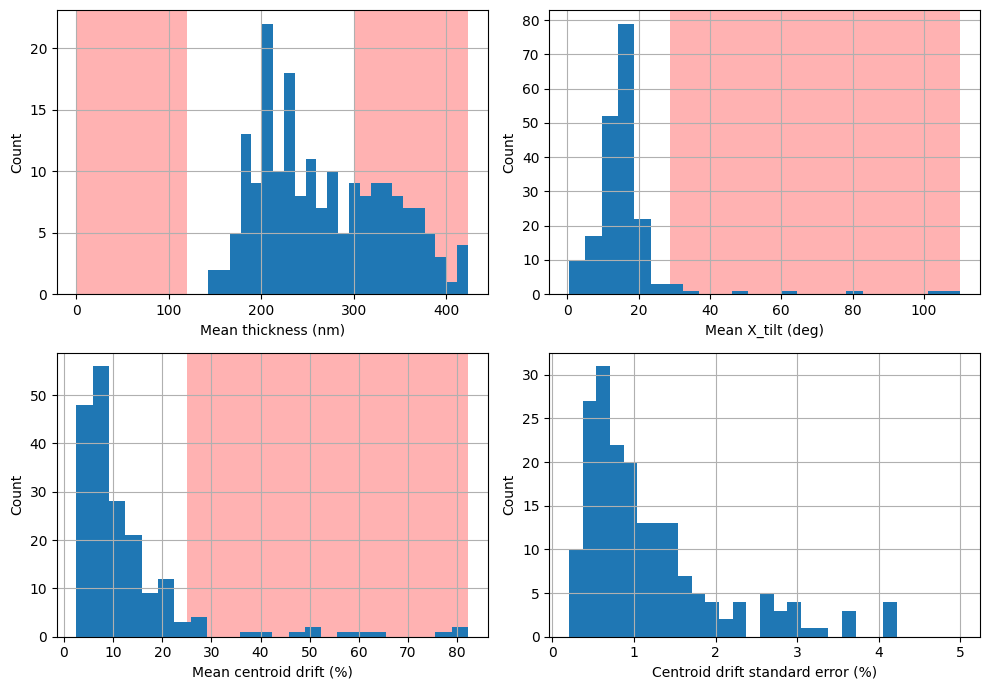

In [10]:
nbins = 4 * np.ceil(np.cbrt(len(df["metrics"]))).astype(int)

filtered_xtilts = df["metrics"][~df['analytics']['Anom_xtilt_out_of_range']]['Mean_X-tilt_degs']
xtilt_thres = [filtered_xtilts.min(), filtered_xtilts.max()]

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0][0].axvspan(0, df["metadata"]["thickness_lower_limit"][0], facecolor='r', alpha=0.3)
ax[0][0].axvspan(df["metadata"]["thickness_upper_limit"][0], df["metrics"]["Mean_thickness_nm"].max(), facecolor='r', alpha=0.3)

ax[0][1].axvspan(min(df["metrics"]["Mean_X-tilt_degs"].min(), xtilt_thres[0]), max(df["metrics"]["Mean_X-tilt_degs"].min(), xtilt_thres[0]), facecolor='r', alpha=0.3)
ax[0][1].axvspan(min(df["metrics"]["Mean_X-tilt_degs"].max(), xtilt_thres[1]), max(df["metrics"]["Mean_X-tilt_degs"].max(), xtilt_thres[1]), facecolor='r', alpha=0.3)

ax[1][0].axvspan(df["metadata"]["displacement_limit"][0], df["metrics"]["Mean_drift_perc"].max(), facecolor='r', alpha=0.3)
ax[1][1].axvspan(df["metadata"]["displacement_std_limit"][0], max(df["metadata"]["displacement_std_limit"][0], df["metrics"]["Drift_SEM_perc"].max()), facecolor='r', alpha=0.3)

df["metrics"][["Mean_thickness_nm", "Mean_X-tilt_degs", "Mean_drift_perc", "Drift_SEM_perc"]].hist(bins=nbins, ax=ax)

for axis in ax.flatten():
    axis.set_title("")
    axis.set_ylabel("Count")

ax[0][0].set_xlabel("Mean thickness (nm)")
ax[0][1].set_xlabel("Mean X_tilt (deg)")
ax[1][0].set_xlabel("Mean centroid drift (%)")
ax[1][1].set_xlabel("Centroid drift standard error (%)")

plt.tight_layout()

## Feature clustering

In [11]:
use_data = df['analytics'][['Anom_too_thin', 'Anom_too_thick', 'Anom_thick_uncertain', 'Anom_xtilt_out_of_range', 'Anom_xtilt_uncertain', 'Anom_centroid_displaced', 'Anom_wild_drift']]

n_neighbours = np.cbrt(len(use_data)).astype(int)
ump = UMAP(n_components=2, n_neighbors=n_neighbours, init="random", random_state=1)
ump_latent = ump.fit_transform(use_data)

dbscan = DBSCAN(eps=1)
ump_latent_clustered = dbscan.fit_predict(ump_latent)

cluster_centroids = np.array([np.mean(ump_latent[ump_latent_clustered==i], axis=0) for i in np.unique(ump_latent_clustered)])
if len(cluster_centroids) >= 4:
    vor = Voronoi(cluster_centroids)
else:
    print(f"WARNING: >4 clusters needed for Voronoi tesselation but only {len(cluster_centroids)} found.")

In [12]:
ptp_bound = np.ptp(ump_latent, axis=0)
points_tr = ump_latent.T

bounding_box = np.array([
    [points_tr[0].min() - ptp_bound[0]*0.1, points_tr[1].min() - ptp_bound[1]*0.1],
    [points_tr[0].min() - ptp_bound[0]*0.1, points_tr[1].max() + ptp_bound[1]*0.1],
    [points_tr[0].max() + ptp_bound[0]*0.1, points_tr[1].max() + ptp_bound[1]*0.1],
    [points_tr[0].max() + ptp_bound[0]*0.1, points_tr[1].min() - ptp_bound[1]*0.1],
])
xmin, xmax, ymin, ymax = [
    points_tr[0].min() - ptp_bound[0]*0.1, 
    points_tr[0].max() + ptp_bound[0]*0.1, 
    points_tr[1].min() - ptp_bound[1]*0.1, 
    points_tr[1].max() + ptp_bound[1]*0.1
]

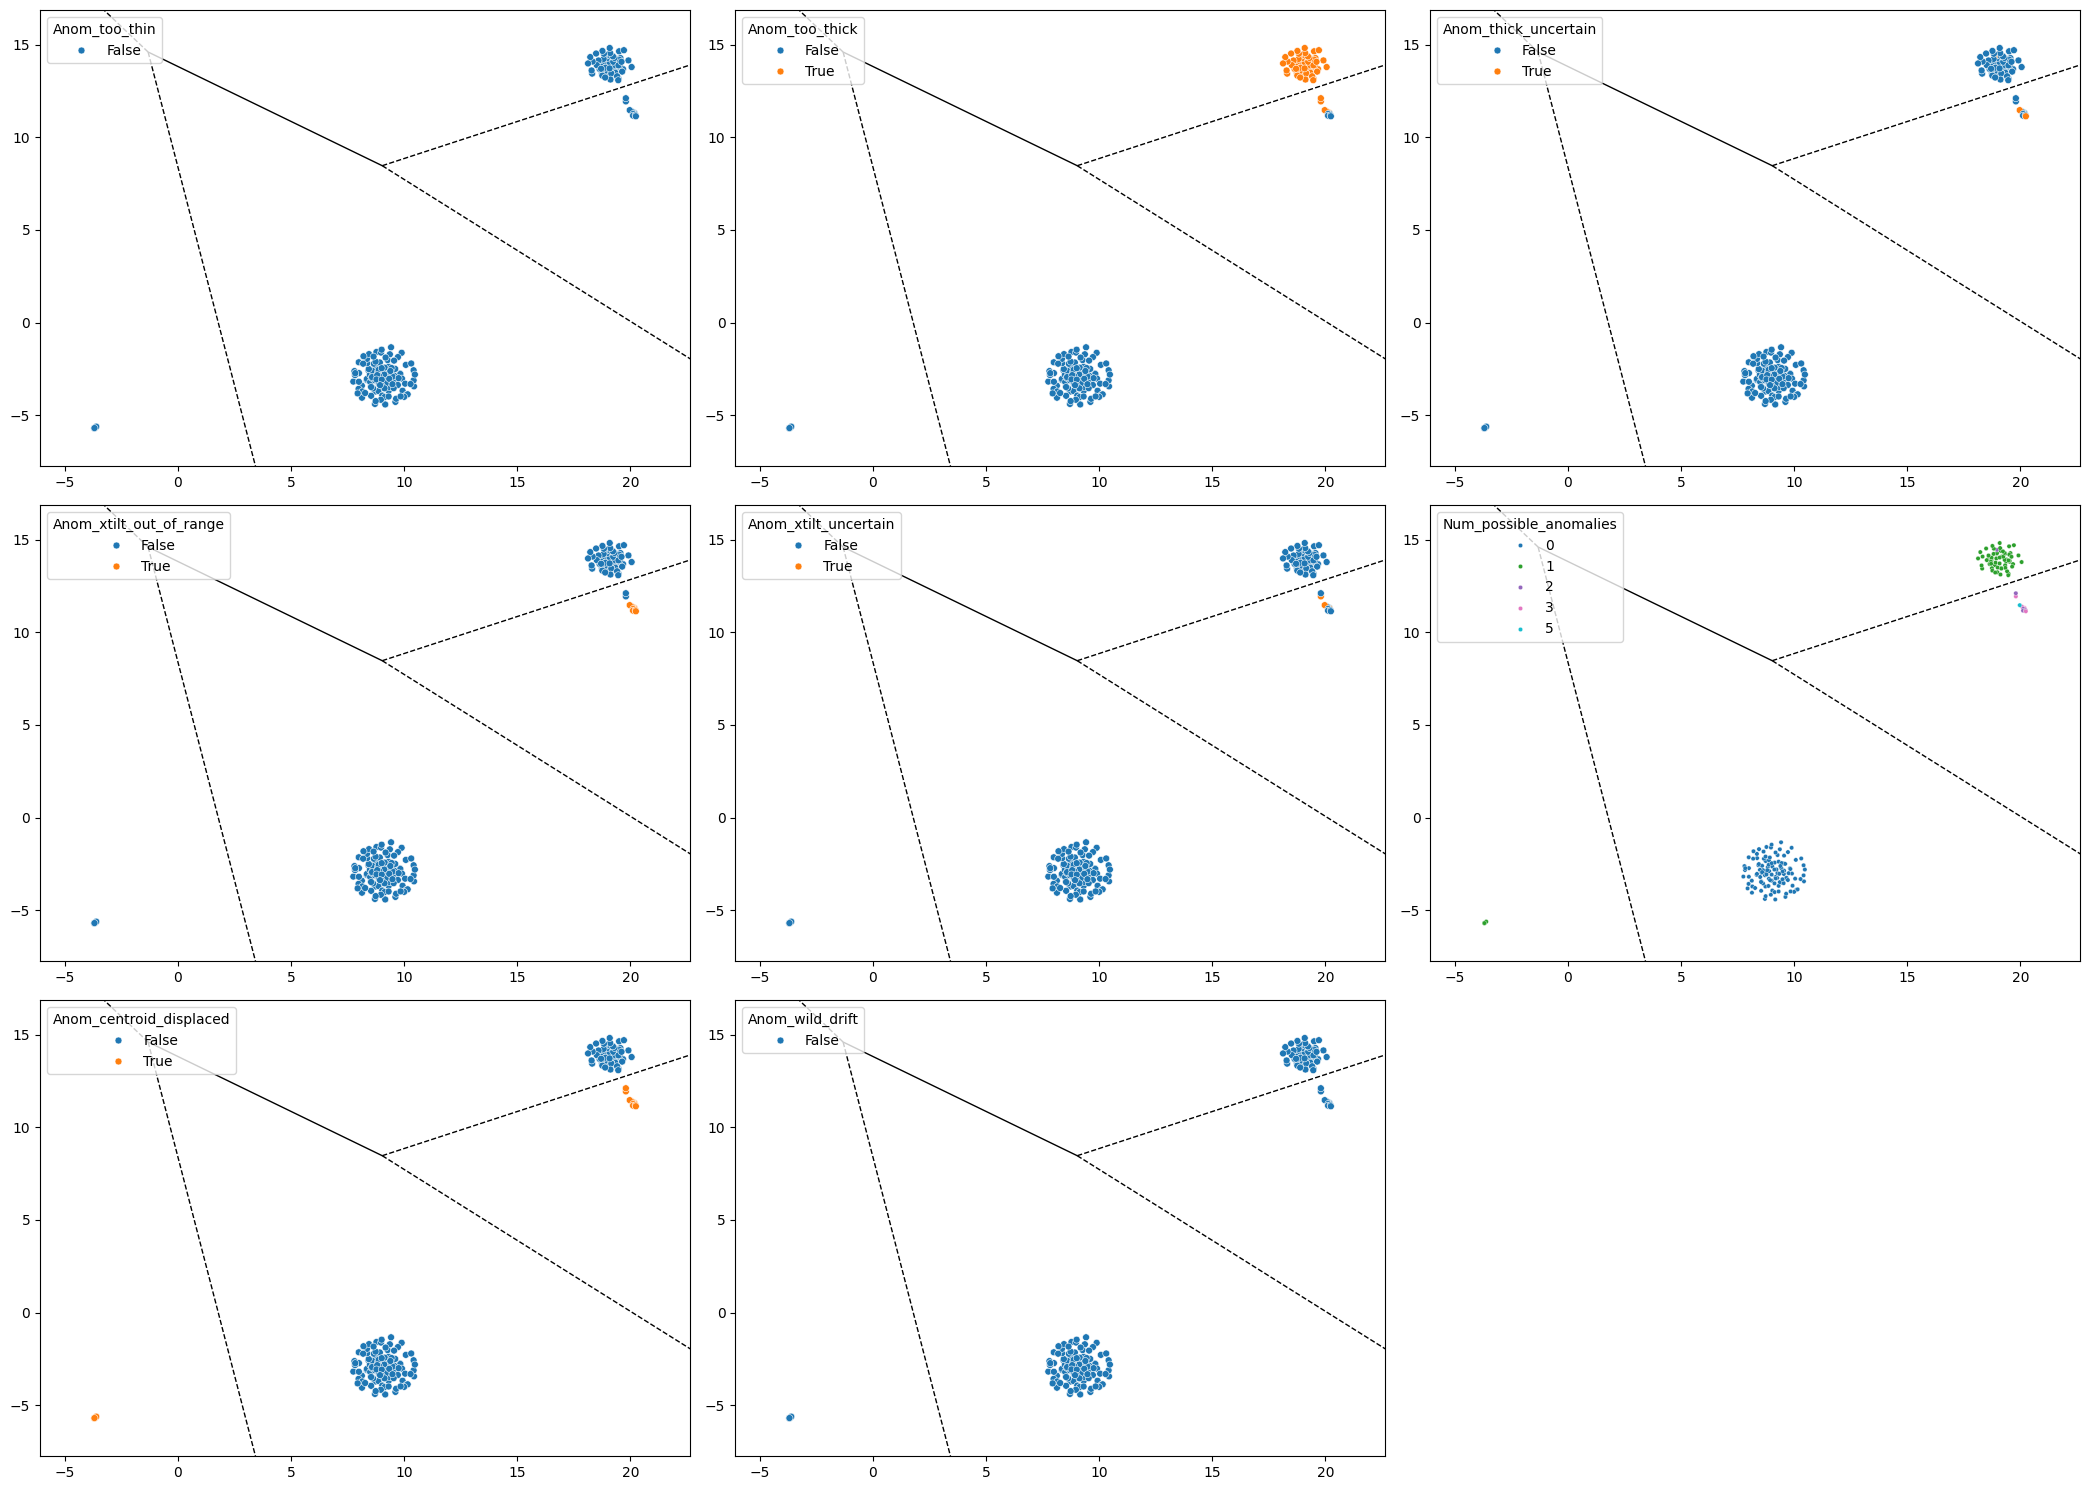

In [13]:
fig = plt.figure(figsize=(21, 15))
ax00 = fig.add_subplot(3, 3, 1)
ax01 = fig.add_subplot(3, 3, 2)
ax02 = fig.add_subplot(3, 3, 3)
ax10 = fig.add_subplot(3, 3, 4)
ax11 = fig.add_subplot(3, 3, 5)
ax12 = fig.add_subplot(3, 3, 6)
ax20 = fig.add_subplot(3, 3, 7)
ax21 = fig.add_subplot(3, 3, 8)
# all_axes = [ax00, ax01, ax02, ax10, ax11, ax12, ax20, ax21]

sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_too_thin"], ax=ax00, s=25)
sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_too_thick"], ax=ax01, s=25)
sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_thick_uncertain"], ax=ax02, s=25)

sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_xtilt_out_of_range"], ax=ax10, s=25)
sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_xtilt_uncertain"], ax=ax11, s=25)
sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Num_possible_anomalies"], palette="tab10", ax=ax12, s=10)

sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_centroid_displaced"], ax=ax20, s=25)
sns.scatterplot(x=ump_latent[:, 0], y=ump_latent[:, 1], hue=df['analytics']["Anom_wild_drift"], ax=ax21, s=25)

if len(cluster_centroids) >= 4:
    for ax in [ax00, ax01, ax02, ax10, ax11, ax12, ax20, ax21]:
        voronoi_plot_2d(vor, show_points=False, show_vertices=False, ax=ax)
    
        ax.set_xlim(left=xmin, right=xmax)
        ax.set_ylim(bottom=ymin, top=ymax)
        
plt.tight_layout()

## Quality summary

In [14]:
df_merged = df['metrics'].merge(df['analytics'], on="filename")[list(df['metrics'].keys())+["Num_possible_anomalies"]].sort_values(by="Num_possible_anomalies", ascending=False)
df_merged

filename  binning  Mean_thickness_nm  \
159   Position_67_bin8_filtered.mrc        4         344.253380   
30   Position_120_bin8_filtered.mrc        4         275.467283   
28   Position_119_bin8_filtered.mrc        4         323.366315   
174   Position_82_bin8_filtered.mrc        4         294.723091   
27   Position_118_bin8_filtered.mrc        4         338.371688   
..                              ...      ...                ...   
189   Position_97_bin8_filtered.mrc        4         252.176145   
190   Position_98_bin8_filtered.mrc        4         221.190212   
191   Position_99_bin8_filtered.mrc        4         281.904592   
80   Position_166_bin8_filtered.mrc        4         209.427540   
81   Position_167_bin8_filtered.mrc        4         230.574952   

     Thickness_SEM_nm  Mean_X-tilt_degs  X-tilt_SEM_degs  Mean_Y-tilt_degs  \
159         18.938610         50.527217         5.054299         69.985767   
30           6.949898         63.201634         5.649657         91.336409   
28           3.712744         21.130884         7.776095         56.815321   
174         16.282469        102.869951         3.528352         89.919011   
27           9.553330         32.385380         1.421945         37.228962   
..                ...               ...              ...               ...   
189          6.950797         12.869987         0.169382          0.736468   
190          2.556502         14.184351         0.325532         -0.138546   
191          2.218819         13.914349         0.521484          2.577245   
80           1.471842         15.216701         0.166247          4.117241   
81           1.583315         16.519416         0.114322          3.740161   

     Y-tilt_SEM_degs  Mean_drift_perc  Drift_SEM_perc  Num_possible_anomalies  
159         3.897269        58.938902        3.662082                       5  
30          2.343161        64.702952        1.800199                       3  
28          4.947472        61.219207        0.653599                       3  
174         0.979111        76.468632        1.047825                       3  
27          6.798713        49.317922        0.880533                       3  
..               ...              ...             ...                     ...  
189         0.237144         4.178729        0.314710                       0  
190         0.408918         3.081802        0.202077                       0  
191         0.290640         7.408139        0.572411                       0  
80          0.172707         6.056305        0.324810                       0  
81          0.159935         3.756036        0.460275                       0  

[192 rows x 11 columns]

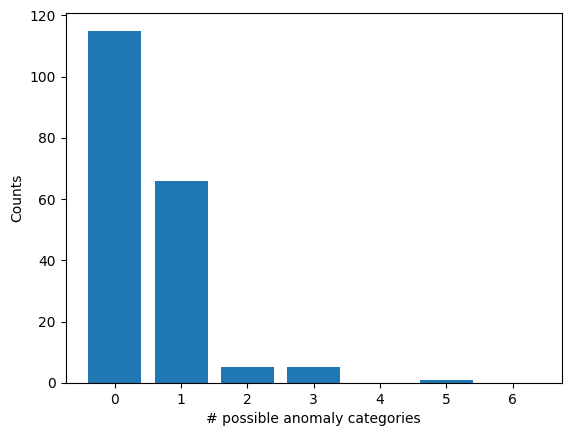

In [15]:
anomalies_count = [len(df_merged[df_merged.Num_possible_anomalies==i]) for i in range(7)]

fig, ax = plt.subplots()
_ = ax.bar(range(7), anomalies_count)
_ = ax.set_ylabel("Count")
_ = ax.set_xlabel("# possible anomaly categories")

## Distribution of anomaly categories

In [16]:
cats = df['analytics'][[cat for cat in df['analytics'].columns if cat.startswith('Anom_')]]

cats_count = cats.apply(pd.Series.value_counts)
cats_count.fillna(value=0, inplace=True)
cats_count.index.name="Results"
cats_count = cats_count.rename(columns=
                               {
                                   "Anom_too_thin": "Too thin",
                                   "Anom_too_thick": "Too thick",
                                   "Anom_thick_uncertain": "Thickness uncertain",
                                   "Anom_xtilt_out_of_range": "X-tilt out-of-range",
                                   "Anom_xtilt_uncertain": "X-tilt uncertain",
                                   "Anom_centroid_displaced": "Centroid displaced",
                                   "Anom_wild_drift": "Wild drift"
                               }
                              )

cats_count.astype(int)


Too thin  Too thick  Thickness uncertain  X-tilt out-of-range  \
Results                                                                  
False         192        125                  189                  184   
True            0         67                    3                    8   

         X-tilt uncertain  Centroid displaced  Wild drift  
Results                                                    
False                 189                 177         192  
True                    3                  15           0

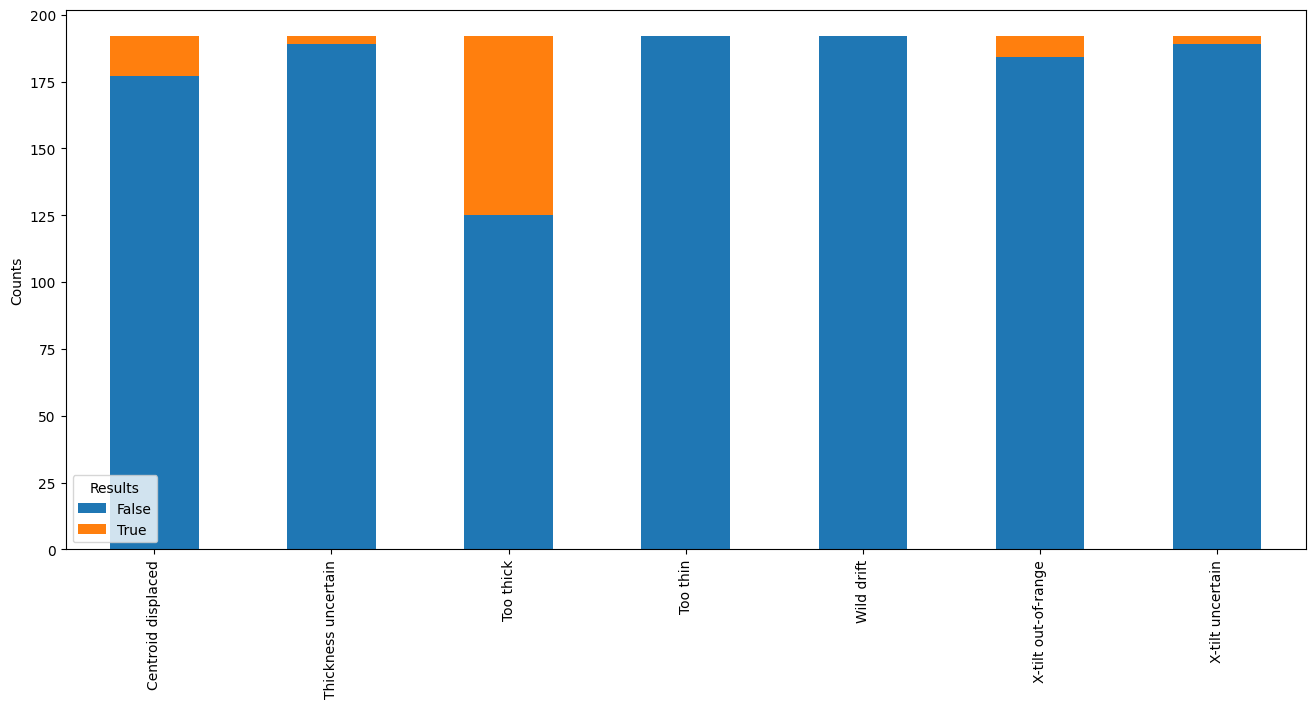

In [17]:
ax = cats_count.transpose().plot.bar(figsize=(16, 7), legend=True, stacked=True)
_ = ax.set_ylabel("Count")


### Datasets with 3+ possible anomaly categories

In [18]:
df_anomalous = df_merged[df_merged.Num_possible_anomalies >= 3].reset_index(drop=True)

pd.set_option("display.max_rows", None)
df_anomalous
# df_anomalous.style.set_caption(f"Datasets with 4+ possible anomaly categories ({len(df_anomalous)})")

filename  binning  Mean_thickness_nm  \
0   Position_67_bin8_filtered.mrc        4         344.253380   
1  Position_120_bin8_filtered.mrc        4         275.467283   
2  Position_119_bin8_filtered.mrc        4         323.366315   
3   Position_82_bin8_filtered.mrc        4         294.723091   
4  Position_118_bin8_filtered.mrc        4         338.371688   
5   Position_35_bin8_filtered.mrc        4         377.466932   

   Thickness_SEM_nm  Mean_X-tilt_degs  X-tilt_SEM_degs  Mean_Y-tilt_degs  \
0         18.938610         50.527217         5.054299         69.985767   
1          6.949898         63.201634         5.649657         91.336409   
2          3.712744         21.130884         7.776095         56.815321   
3         16.282469        102.869951         3.528352         89.919011   
4          9.553330         32.385380         1.421945         37.228962   
5          8.452013         34.599601         4.825607         -3.617968   

   Y-tilt_SEM_degs  Mean_drift_perc  Drift_SEM_perc  Num_possible_anomalies  
0         3.897269        58.938902        3.662082                       5  
1         2.343161        64.702952        1.800199                       3  
2         4.947472        61.219207        0.653599                       3  
3         0.979111        76.468632        1.047825                       3  
4         6.798713        49.317922        0.880533                       3  
5         0.541007        26.061282        2.622134                       3

## Plotting of potentially anomalous datasets (with 3+ categories)

In [44]:
anomalous_file_paths = [df['metadata']['data_source'][0]+df_anomalous['filename'][i] for i in range(len(df_anomalous))]
anomalous_file_models = [df['metadata']['model_folder'][0]+Path(df_anomalous['filename'][i]).stem+".png" for i in range(len(df_anomalous))]


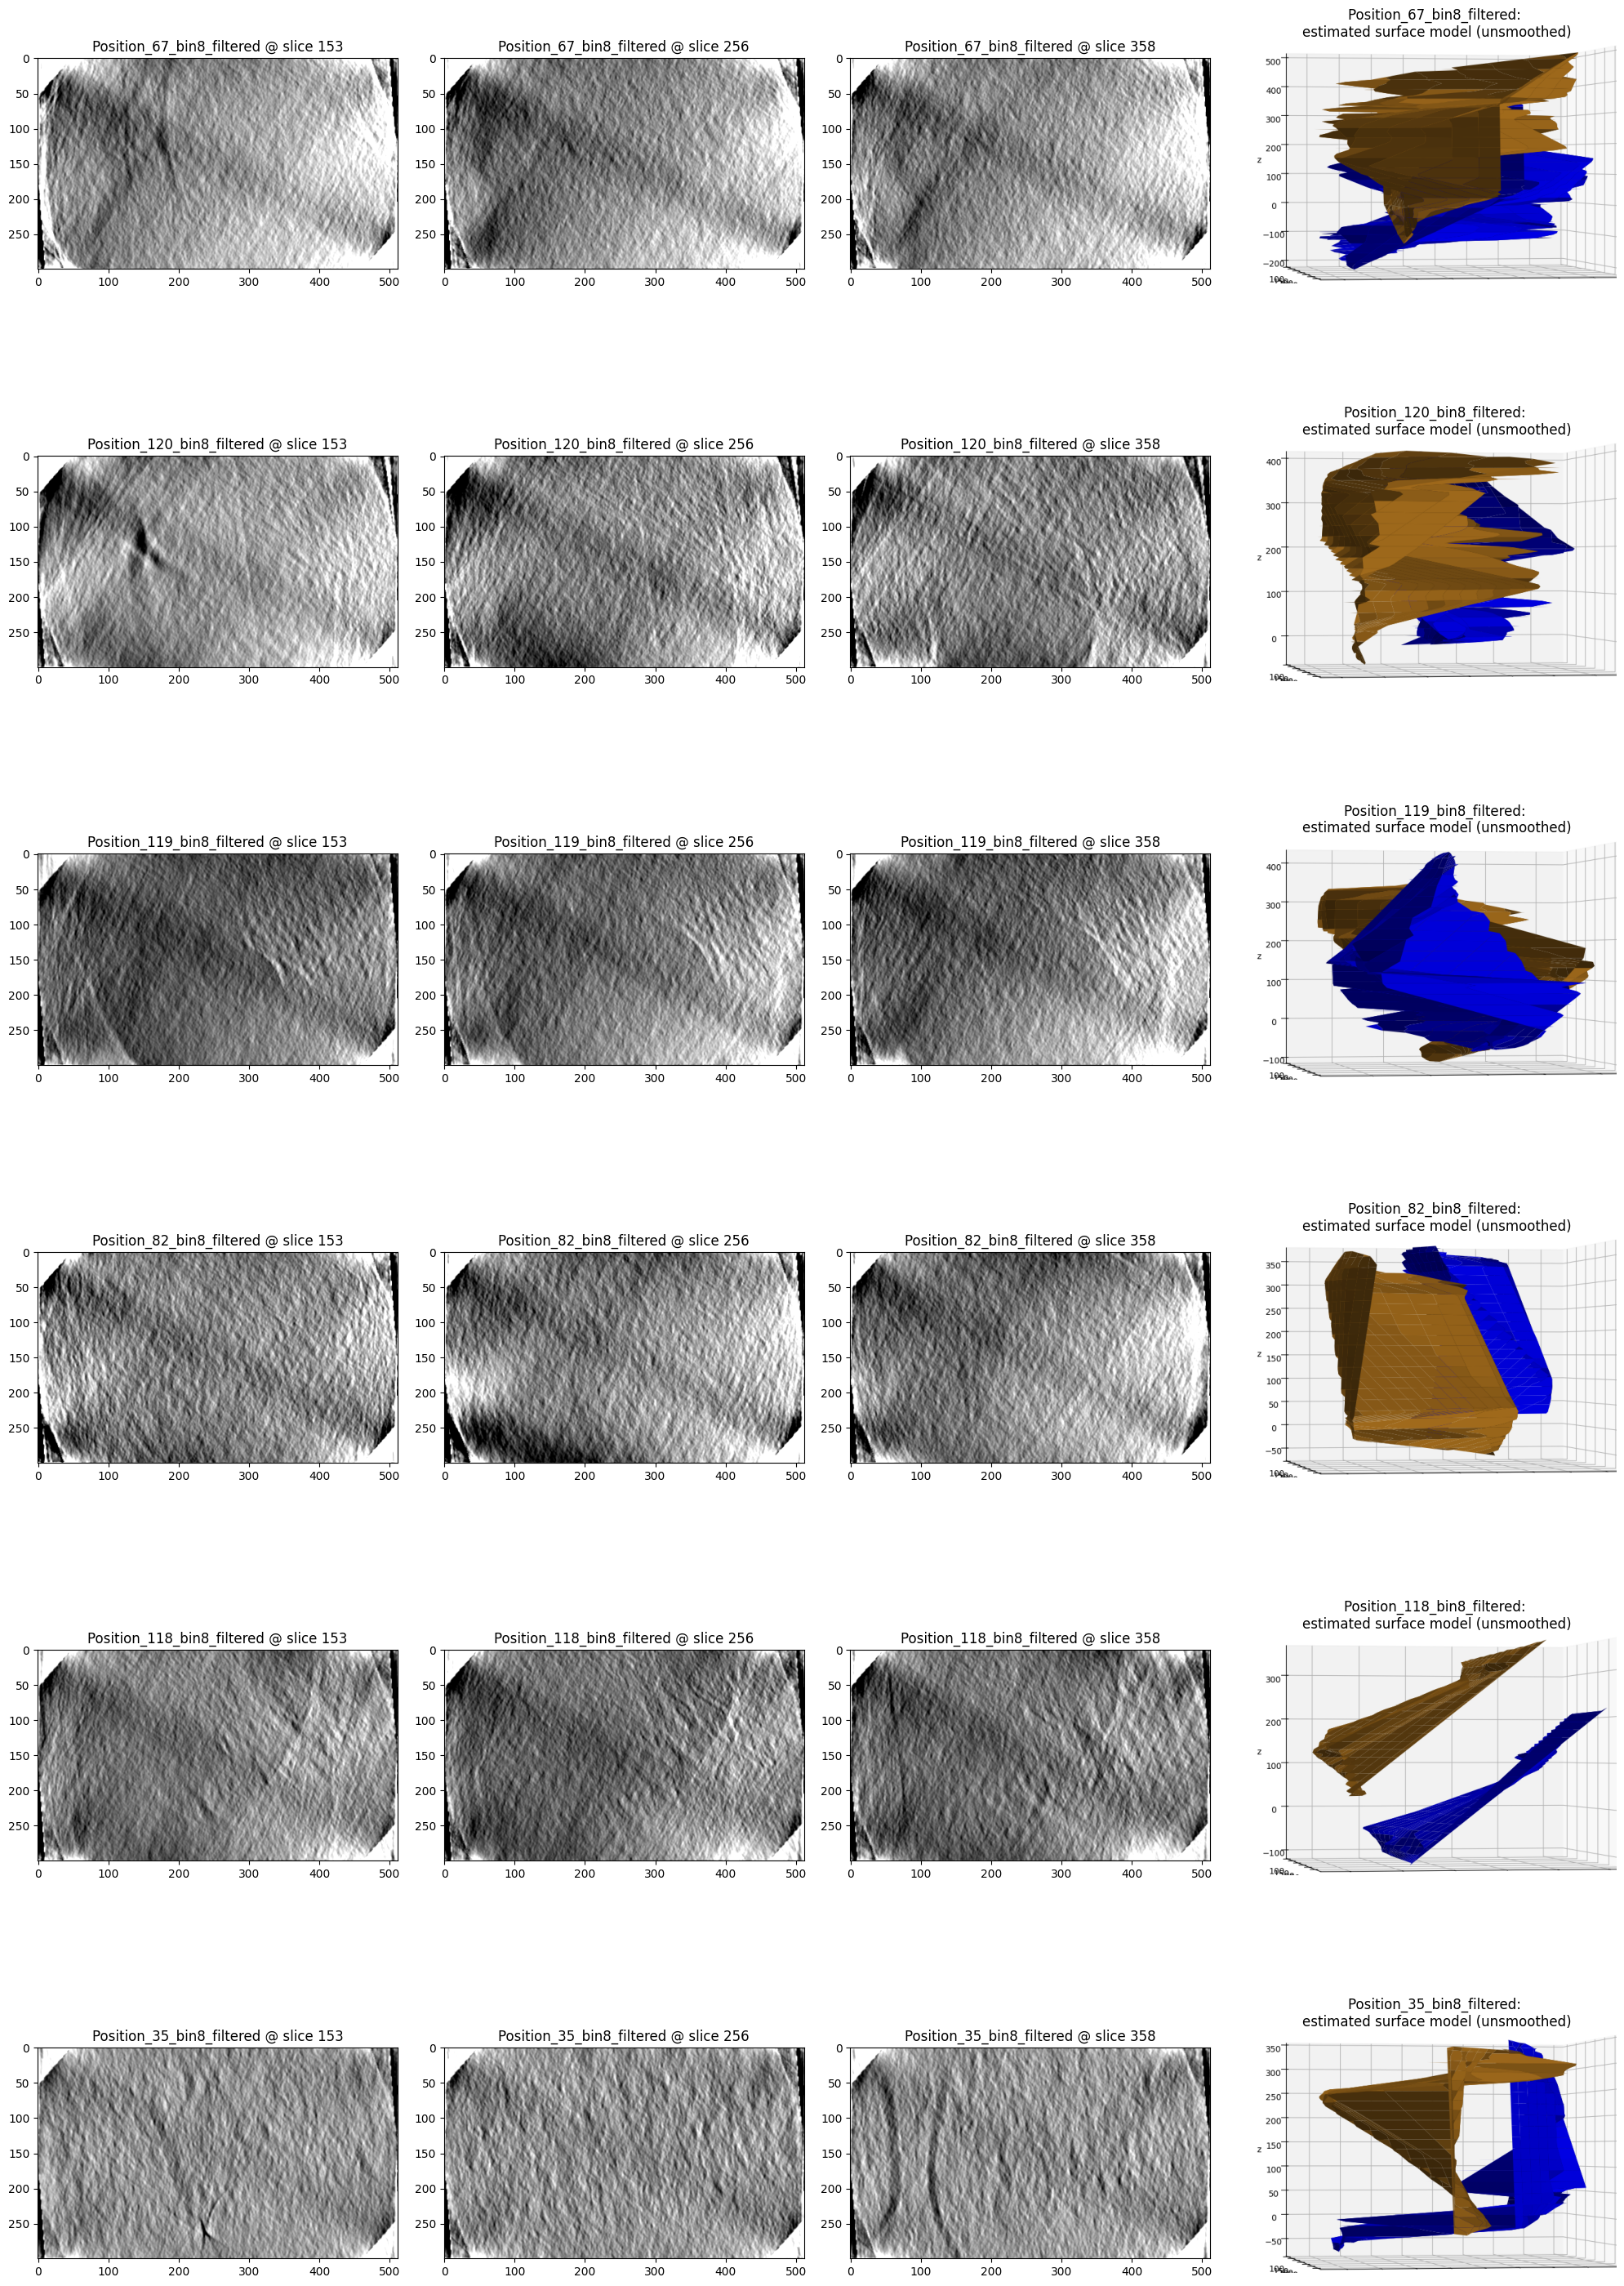

In [43]:
if len(anomalous_file_paths) > 0:
    display_files = anomalous_file_paths
    if len(anomalous_file_paths) > 25:
        print(f"WARNING: Too many potentially anomalous tomograms {len(anomalous_file_paths)}, only showing top 25")
        display_files = anomalous_file_paths[:25]
    
    fig, ax = plt.subplots(len(display_files), 4, figsize=(20, 5*len(display_files)))
    if len(anomalous_file_paths) == 1:
        ax = ax[np.newaxis, ...]
    
    for idx, curr_file in enumerate(display_files):
        with mrcfile.open(display_files[idx]) as f:
            data = f.data
            num_slices = data.shape[1]
    
        zlims = np.array([data.shape[0]*0.3, data.shape[0]*0.7]).astype(int)
        ylims = np.array([data.shape[2]*0.3, data.shape[2]*0.7]).astype(int)
    
        plot_1 = np.clip(data[:, int(num_slices*0.3), :], a_min=data[zlims[0]:zlims[1], int(num_slices*0.3), ylims[0]:ylims[1]].min(), a_max=data[zlims[0]:zlims[1], int(num_slices*0.3), ylims[0]:ylims[1]].max())
        plot_2 = np.clip(data[:, int(num_slices*0.5), :], a_min=data[zlims[0]:zlims[1], int(num_slices*0.5), ylims[0]:ylims[1]].min(), a_max=data[zlims[0]:zlims[1], int(num_slices*0.5), ylims[0]:ylims[1]].max())
        plot_3 = np.clip(data[:, int(num_slices*0.7), :], a_min=data[zlims[0]:zlims[1], int(num_slices*0.7), ylims[0]:ylims[1]].min(), a_max=data[zlims[0]:zlims[1], int(num_slices*0.7), ylims[0]:ylims[1]].max())
        
        ax[idx][0].imshow(plot_1, cmap="gray")
        ax[idx][1].imshow(plot_2, cmap="gray")
        ax[idx][2].imshow(plot_3, cmap="gray")
        ax[idx][3].imshow(model:=cv2.imread(anomalous_file_models[idx])[300:700, 200:800])
        ax[idx][3].axis('off')
    
        ax[idx][0].title.set_text(f"{Path(curr_file).stem} @ slice {int(num_slices*0.3)}")
        ax[idx][1].title.set_text(f"{Path(curr_file).stem} @ slice {int(num_slices*0.5)}")
        ax[idx][2].title.set_text(f"{Path(curr_file).stem} @ slice {int(num_slices*0.7)}")
        ax[idx][3].title.set_text(f"{Path(curr_file).stem}: \nestimated surface model (unsmoothed)")
    
    plt.tight_layout()
    